#### Step 1: Setup and Getting Data



In [1]:
!nvidia-smi

Mon Oct 20 01:32:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.7.4.2 --quiet
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"erickumara","key":"ef3183b6e235dac70c2d15665a8216d6"}')

!chmod 600 /root/.kaggle/kaggle.json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 5.7 MB/s eta 0:00:00


In [3]:
# Datasets
# https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset 7 columns
# https://www.kaggle.com/datasets/llabhishekll/fraud-email-dataset 2 columns

!mkdir '/content/data'

!kaggle datasets download -d naserabdullahalam/phishing-email-dataset
!unzip -qo 'phishing-email-dataset.zip' -d '/content/data'
!rm 'phishing-email-dataset.zip'

!kaggle datasets download -d llabhishekll/fraud-email-dataset
!unzip -qo 'fraud-email-dataset.zip' -d '/content/data'
!rm 'fraud-email-dataset.zip'

Dataset URL: https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset
License(s): CC-BY-SA-4.0
Dataset URL: https://www.kaggle.com/datasets/llabhishekll/fraud-email-dataset
License(s): unknown


#### Step 2: Data-preprocessing

In [4]:
import os
import pandas as pd

all_df = []
data_path = '/content/data'
for file in os.listdir(data_path):
    df = pd.read_csv(os.path.join(data_path, file))
    all_df.append(df)
    print(f"File Name: {file} \n {df.iloc[0]} \n")

columns = ["body", "label"]
final_df = pd.concat(all_df)[columns]
final_df.head()


File Name: SpamAssasin.csv 
 sender                         Robert Elz <kre@munnari.OZ.AU>
receiver    Chris Garrigues <cwg-dated-1030377287.06fa6d@D...
date                          Thu, 22 Aug 2002 18:26:25 +0700
subject                              Re: New Sequences Window
body        Date:        Wed, 21 Aug 2002 10:54:46 -0500  ...
label                                                       0
urls                                                        1
Name: 0, dtype: object 

File Name: fraud_email_.csv 
 Text     Supply Quality China's EXCLUSIVE dimensions at...
Class                                                    1
Name: 0, dtype: object 

File Name: Nazario.csv 
 sender      Mail System Internal Data <MAILER-DAEMON@monke...
receiver                                                  NaN
date                               28 Sep 2017 09:57:25 -0400
subject     DON'T DELETE THIS MESSAGE -- FOLDER INTERNAL DATA
body        This text is part of the internal format of yo...
urls

,body,label
0,"Date: Wed, 21 Aug 2002 10:54:46 -0500 ...",0.0
1,"Martin A posted:\nTassos Papadopoulos, the Gre...",0.0
2,Man Threatens Explosion In Moscow \n\nThursday...,0.0
3,Klez: The Virus That Won't Die\n \nAlready the...,0.0
4,"> in adding cream to spaghetti carbonara, whi...",0.0


In [5]:
# mask the URL pre processing
import re
url_pattern = r'(https?://|www\.)\S+'
mask_token = '[URL]'
final_df.dropna(inplace=True)
final_df = final_df.replace(to_replace=url_pattern, value=mask_token, regex=True)

In [6]:
final_df['label'].value_counts()

,count
label,
1.0,42890
0.0,39595


In [7]:
final_df.sample(5)

,body,label
2000,"Hello My Dear,\n\nMy Name is Mr.Peter Herry, t...",1.0
4810,Apologies to those of you who receive this mor...,0.0
13477,Robert Elz on wrote... | Date: Tue...,0.0
2944,"\nI am Mr Ying Cheng, a principal partner with...",1.0
3802,"On Wed, Aug 21, 2002 at 11:26:13AM -0500, brad...",0.0


#### Step 3: Splitting Data

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final_df['body'], final_df['label'], stratify=final_df['label'])

X_train.head()


,body
29948,\n\n\n\n\n\n\nInst ssw ant Online Payday Loans...
4485,Opportunity is knocking. Why? Because mortgage...
1658,>From The Desk Of Dr Solomon Richards\nMD/CEO ...
41,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...
18292,\n\n\nOne of the leading online health shops t...


#### Step 4: Model

In [9]:
!pip install tensorflow_text

In [10]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

class Preprocess_Layer(tf.keras.layers.Layer):
    def call(self, inputs):
        return bert_preprocess(inputs)

class Bert_Embedding_Layer(tf.keras.layers.Layer):
    def call(self, inputs):
        return bert_model(inputs)

# bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
encoder_inputs = Preprocess_Layer()(text_input)
outputs = Bert_Embedding_Layer()(encoder_inputs)

# neural network layers
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

# construct final model
model = tf.keras.Model(inputs=[text_input], outputs=[l])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocess__layer   │ [(None, 128),     │          0 │ text[0][0]        │
│ (Preprocess_Layer)  │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert__embedding__l… │ [(None, 768),     │          0 │ preprocess__laye… │
│ (Bert_Embedding_La… │ (None, 128, 768), │            │ preprocess__laye… │
│                     │ (None, 128, 768), │            │ preprocess__laye… │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 768),      │            │                   │
│                     │ (None, 128, 768)] │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 768)       │          0 │ bert__embedding_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        769 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

#### Step 5: Training

In [11]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='prediction'),
    tf.keras.metrics.Recall(name='recall')
]

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS,
              jit_compile=False)

In [12]:
X_train_tensor = tf.constant(X_train.values, dtype=tf.string)
y_train_tensor = tf.constant(y_train.values, dtype=tf.int32)

with tf.device('/GPU:0'):
  model.fit(X_train_tensor, y_train_tensor, epochs=10)

Epoch 1/10
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 664s 332ms/step - accuracy: 0.5897 - loss: 0.6733 - prediction: 0.5853 - recall: 0.7569
Epoch 2/10
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 645s 333ms/step - accuracy: 0.6847 - loss: 0.6058 - prediction: 0.6862 - recall: 0.7242
Epoch 3/10
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 645s 333ms/step - accuracy: 0.7219 - loss: 0.5710 - prediction: 0.7230 - recall: 0.7552
Epoch 4/10
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 644s 333ms/step - accuracy: 0.7549 - loss: 0.5412 - prediction: 0.7546 - recall: 0.7854
Epoch 5/10
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 645s 333ms/step - accuracy: 0.7753 - loss: 0.5170 - prediction: 0.7698 - recall: 0.8095
Epoch 6/10
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 647s 334ms/step - accuracy: 0.7938 - loss: 0.4985 - prediction: 0.7881 - recall: 0.8233
Epoch 7/10
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 648s 335ms/step - accuracy: 0.8081 - loss: 0.4790 - prediction: 0.8013 - recall: 0.8379
Epoch 8/10
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 648s 335ms/step - accuracy: 0.8162 - loss: 0.462

In [13]:
X_test_tensor = tf.constant(X_test.values, dtype=tf.string)
y_test_tensor = tf.constant(y_test.values, dtype=tf.int32)

model.evaluate(X_test_tensor, y_test_tensor)

645/645 ━━━━━━━━━━━━━━━━━━━━ 254s 392ms/step - accuracy: 0.8474 - loss: 0.4178 - prediction: 0.8325 - recall: 0.8858


[0.41795605421066284,
 0.8462321758270264,
 0.8309957981109619,
 0.8840809464454651]

In [14]:
y_predicted = model.predict(X_test_tensor)
y_predicted = y_predicted.flatten()

645/645 ━━━━━━━━━━━━━━━━━━━━ 250s 387ms/step


In [15]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, ..., 0, 1, 1])

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[7971, 1928],
       [1243, 9480]])

Text(50.722222222222214, 0.5, 'Truth')

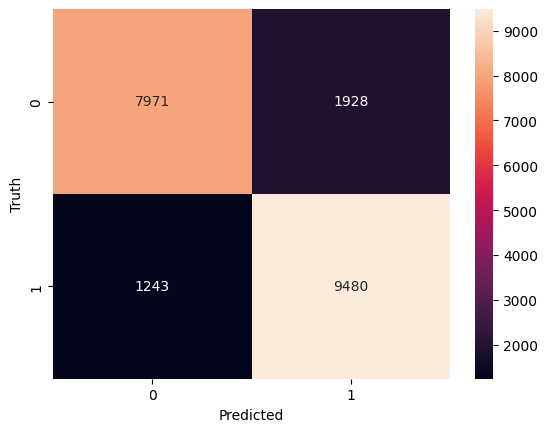

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [18]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

         0.0       0.87      0.81      0.83      9899
         1.0       0.83      0.88      0.86     10723

    accuracy                           0.85     20622
   macro avg       0.85      0.84      0.85     20622
weighted avg       0.85      0.85      0.85     20622

